# P300 Detection Using Muse Headband and Classifying Algorithms

In [90]:
#Necessary imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from eegnb import generate_save_fn
from collections import OrderedDict
from mne import Epochs,find_events
from mne.decoding import Vectorizer
from eegnb.analysis.utils import load_data,plot_conditions
from eegnb.datasets import fetch_dataset


from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from pyriemann.estimation import Xdawn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

## I am using sample data collected by an InteraXon Muse EEG Headset by Alexandre Barachant. It uses the Oddball paradigm, a method where the subject is presented with many non-target stimuli (visual, in this case), that are interjected with a few target stimuli. This experiment consisted of 6 trials of 2 minutes each. The data is open and available for download through EEG-Notebooks.

In [2]:
#load data from EEG-Notebooks 
eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')  
#fetch_dataset(data_dir=eegnb_data_path, experiment='visual-P300', site='eegnb_examples')
sub = 1
sess = 1
dataset = load_data(sub,sess, experiment='visual-P300', site='eegnb_examples', device_name='muse2016', data_dir = eegnb_data_path)

['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10',

## Power spectral density plots show how the contributions of power are distributed over a range of frequencies.  
  
## ERP (event-related potential) compenents - like P300 - tend to be in the lower frequency range, which is why I am filtering out frequencies 0-30 here so that we can see them better. I chose an infinite impulse response filter (IIR), which uses less calculations and memory than finite impulse response filters, making it ideal for neural signal processing. 

Effective window size : 8.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


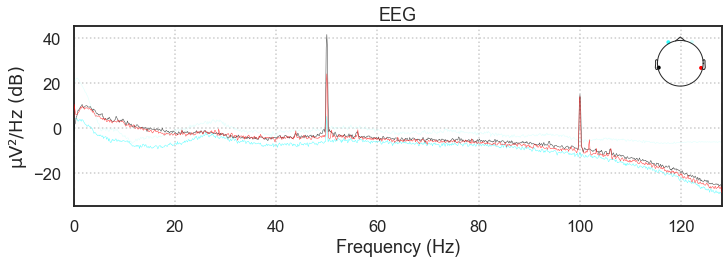

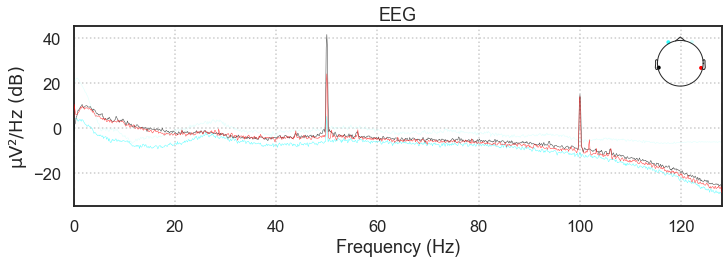

In [3]:
#plotting and filtering the power spectrum 
dataset.plot_psd()

In [4]:
dataset.filter(l_freq= 1, h_freq = 30, method='iir')


Filtering raw data in 6 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



<RawArray | 6 x 184392 (720.3 s), ~8.5 MB, data loaded>

## Epoching: Next, I will parse the data into arrays containing event data from 100 ms before until 800 ms after the stimulus, as well as data on whether the stimulus was target or non-target. 

In [15]:
# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(dataset)
stim_id = {'Non-Target': 1, 'Target': 2}
epochs = Epochs(dataset, events=events, event_id=stim_id,
                tmin=-0.1, tmax=0.8, baseline=None, reject={'eeg': 100e-6}, preload=True, verbose=False, picks=[0,1,2,3])

print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

epochs

1161 events found
Event IDs: [1 2]
sample drop %:  1.5503875968992276


Number of events,1143
Events,Non-Target: 959Target: 184
Time range,-0.102 – 0.801 sec
Baseline,off


(0.2, 0.9)

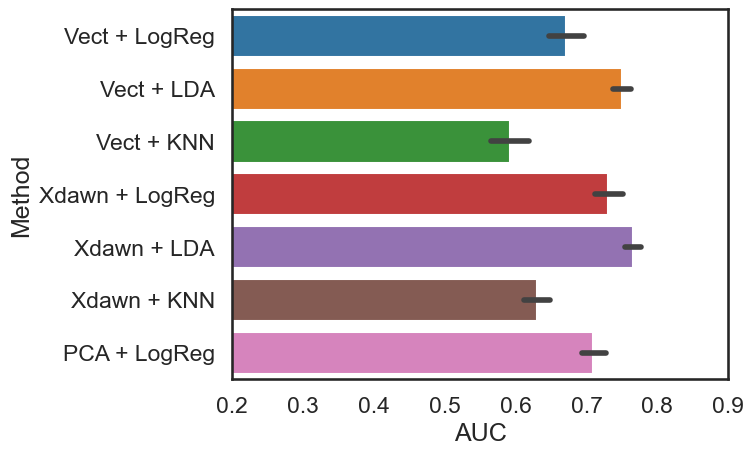

In [92]:
#prepare data for classification 
x = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

#cross validation  
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3)

#classifiers 
clfs = OrderedDict()
clfs['Vect + LogReg'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(max_iter = 10000))
clfs['Vect + LDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Vect + KNN'] = make_pipeline(Vectorizer(), StandardScaler(), KNeighborsClassifier())

clfs['Xdawn + LogReg'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LogisticRegression(max_iter = 10000))
clfs['Xdawn + LDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + KNN'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), KNeighborsClassifier())

clfs['PCA + LogReg'] = make_pipeline(Vectorizer(), PCA(), LogisticRegression(max_iter = 10000))


# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv)
    auc.extend(res)
    methods.extend([m]*len(res))
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.9)

## XDawn + LDA classifier performed the best, with Vect + LDA and XDawn + LogReg coming in second and third, respectively. This analysis exemplifies that a Muse headband can be used to detect P300 spikes, despite the positioning of the Muse sensors being non-ideally positioned for this purpose. 